In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
if 'ilya' in os.getcwd():
    os.chdir('/Users/ilya/Documents/Kaggle_Bimbo/')
else:
    os.chdir('/Users/margarita/Kaggle/Bimbo/')

Populating the interactive namespace from numpy and matplotlib


In [93]:
os.listdir('.')

['.DS_Store',
 'cliente_tabla.csv',
 'cliente_tabla.csv.zip',
 'producto_tabla.csv',
 'producto_tabla.csv.zip',
 'sample_submission.csv',
 'sample_submission.csv.zip',
 'test.csv',
 'test.csv.zip',
 'town_state.csv',
 'town_state.csv.zip',
 'train.csv',
 'train.csv.zip']

# Data preparation

In [16]:
np.random.seed(0)
n = 74180465 #number of records in file
s = 5 * 10 ** 5 #desired sample size
skip = np.sort(np.random.permutation(n)[:(n-s)])[1:]
df_train = pd.read_csv("train.csv", skiprows=skip)

In [17]:
fields = {'Semana': 'Week_number',
        'Agencia_ID': 'Sale_Depot_ID',
        'Canal_ID': 'Sales_Channel_ID',
        'Ruta_SAK': 'Route_ID',
        'Cliente_ID': 'Client_ID',
        'NombreCliente': 'Client_name',
        'Producto_ID': 'Product_ID',
        'NombreProducto': 'Product_Name',
        'Venta_uni_hoy': 'Sales_unit_this_week',
        'Venta_hoy': 'Sales_this_week',
        'Dev_uni_proxima': 'Returns_unit_next_week',
        'Dev_proxima': 'Returns_next_week',
        'Demanda_uni_equil': 'Demand'}

df_train.rename(columns=fields, inplace=True)

df_train.describe()

,Week_number,Sale_Depot_ID,Sales_Channel_ID,Route_ID,Client_ID,Product_ID,Sales_unit_this_week,Sales_this_week,Returns_unit_next_week,Returns_next_week,Demand
count,500000.000000,500000.000000,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,5.949044,2531.735186,1.381404,2114.089504,1.795905e+06,20848.231814,7.357684,68.441548,0.126874,1.238515,7.269690
std,2.011311,4062.777045,1.457647,1485.948084,1.840653e+06,18662.508712,23.246317,281.101050,3.902278,23.919381,22.352295
min,3.000000,1110.000000,1.000000,1.000000,6.000000e+01,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1312.000000,1.000000,1161.000000,3.541822e+05,1242.000000,2.000000,16.760000,0.000000,0.000000,2.000000
50%,6.000000,1613.000000,1.000000,1286.000000,1.187782e+06,30549.000000,3.000000,30.000000,0.000000,0.000000,3.000000
75%,8.000000,2036.000000,1.000000,2803.000000,2.363804e+06,37427.000000,7.000000,56.250000,0.000000,0.000000,6.000000
max,9.000000,25759.000000,11.000000,9935.000000,1.998863e+07,49994.000000,4800.000000,26392.800000,2400.000000,7320.000000,3600.000000


Так как оценивается качество как среднеквадратическое отклонение логарифмов, то логично перейти к логарифмам

In [18]:
df_train['Log_demand'] = (df_train.Demand + 1).apply(np.log) # log(x+1)

Data with target values under 50: 98.55 %


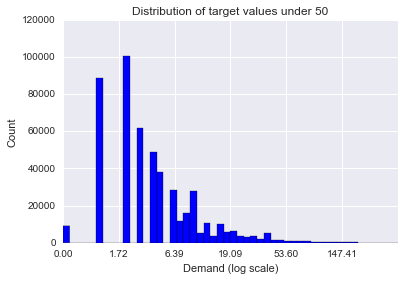

In [19]:
print('Data with target values under 50: %0.2f %%' % ((df_train.Demand < 50).mean()*100))

plt.hist(df_train['Log_demand'], bins=50, color='blue', range=(0, 6))
plt.title('Distribution of target values under 50');plt.xlabel('Demand (log scale)');plt.ylabel('Count')
xvals = ax.get_xticks()
_ = plt.xticks(xvals, ['%0.2f' % (np.exp(int(x))-1) for x in xvals])

Если еще раз логарифмировать - будет нормальное распределение:)

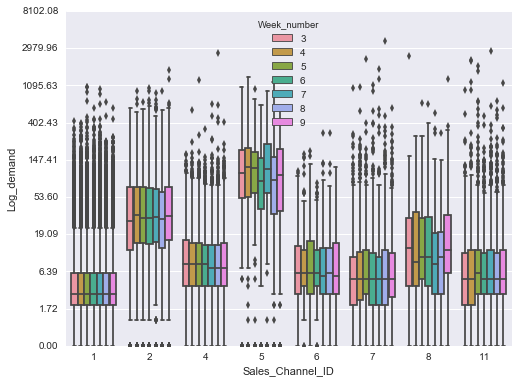

In [20]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x="Sales_Channel_ID", y="Log_demand", hue="Week_number", data=df_train)
yvals = ax.get_yticks()
_ = plt.yticks(yvals, ['%0.2f' % (np.exp(int(x))-1) for x in yvals])

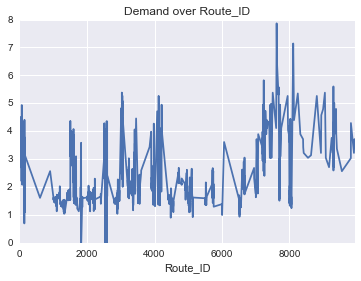

In [21]:
df_train.groupby('Route_ID').Log_demand.mean().plot()
plt.title('Demand over Route_ID')

Всплески как будто на границах областей. Еще области бы добавить - и совсем хорошо будет

In [23]:
os.listdir('.')

['.DS_Store',
 'cliente_tabla.csv',
 'cliente_tabla.csv.zip',
 'producto_tabla.csv',
 'producto_tabla.csv.zip',
 'sample_submission.csv',
 'sample_submission.csv.zip',
 'test.csv',
 'test.csv.zip',
 'town_state.csv',
 'town_state.csv.zip',
 'train.csv',
 'train.csv.zip']

# Towns

In [40]:
town = pd.read_csv('town_state.csv', index_col=0)
town.head()

,Town,State
Agencia_ID,,
1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [41]:
(~town.Town.str[:4].str.isdigit()).sum() #первые 4 числа - номер города

0

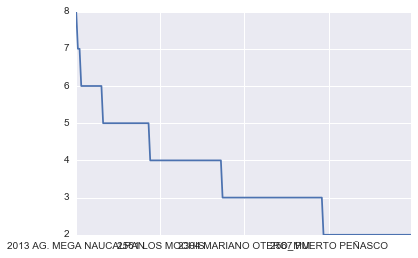

In [42]:
town.Town.value_counts().head(200).plot() #максмум 8 точек

In [43]:
town.State.value_counts()

ESTADO DE MÉXICO         71
MÉXICO, D.F.             65
JALISCO                  55
VERACRUZ                 45
GUANAJUATO               39
PUEBLA                   34
SONORA                   34
NUEVO LEÓN               34
MICHOACÁN                33
TAMAULIPAS               32
BAJA CALIFORNIA NORTE    32
COAHUILA                 29
CHIHUAHUA                25
SINALOA                  23
OAXACA                   22
GUERRERO                 21
HIDALGO                  21
BAJA CALIFORNIA SUR      17
CHIAPAS                  16
SAN LUIS POTOSÍ          15
QUINTANA ROO             14
TABASCO                  14
MORELOS                  14
CAMPECHE                 12
DURANGO                  11
YUCATÁN                  11
ZACATECAS                10
NAYARIT                  10
COLIMA                   10
AGUASCALIENTES            7
TLAXCALA                  6
QUERETARO                 6
Queretaro de Arteaga      2
Name: State, dtype: int64

In [44]:
states_by_town = town.groupby('Town').State.unique().map(len)
town[town.Town.isin(states_by_town[states_by_town > 1].index)]

,Town,State
Agencia_ID,,
1153,2087 AG. TIZAYUCA,HIDALGO
2087,2087 AG. TIZAYUCA,ESTADO DE MÉXICO
3229,2087 AG. TIZAYUCA,HIDALGO
20879,2087 AG. TIZAYUCA,HIDALGO


TIZAYUCA in HIDALGO for sure

# Products

In [5]:
products = pd.read_csv('producto_tabla.csv', index_col=0)
products.head(20)

,NombreProducto
Producto_ID,
0,NO IDENTIFICADO 0
9,Capuccino Moka 750g NES 9
41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
53,Burritos Sincro 170g CU LON 53
72,Div Tira Mini Doradita 4p 45g TR 72
73,Pan Multigrano Linaza 540g BIM 73
98,Tostado Integral 180g WON 98
99,Pan Blanco 567g WON 99
100,Super Pan Bco Ajonjoli 680g SP WON 100


In [86]:
import re

def get_brand(product):
    tokens = product.split(' ')[:-1]
    brand = ''
    for token in tokens[::-1]:
        if token.upper() == token:
            brand = token + ' ' + brand
        else:
            break
    return brand.strip()

products['brand'] = products['NombreProducto'].apply(get_brand)
products['weight'] = products['NombreProducto'].apply(lambda s: re.search("\\d+[Kg|g]", s))
products['weight'][~products['weight'].isnull()] = \
products['weight'][~products['weight'].isnull()].apply(lambda s: re.sub('g', '', re.sub('Kg', '000', s.group(0))))
products['weight'] = pd.to_numeric(products['weight'], errors='coerce')
products['pieces'] = products['NombreProducto'].apply(lambda s: re.search("\\d+p\\b", s))
products['pieces'][~products['pieces'].isnull()] = \
products['pieces'][~products['pieces'].isnull()].apply(lambda s: re.sub('\D', '', s.group(0)))
products['pieces'] = pd.to_numeric(products['pieces'], errors='coerce')
products['Has_choco'] = products['NombreProducto'].apply(lambda s: int(re.search("Choco", s) is not None))
products['Has_vanilla'] = products['NombreProducto'].apply(lambda s: int(re.search("Va(i)?nilla", s) is not None))
products['Has_multigrano'] = products['NombreProducto'].apply(lambda s: int(re.search("Multigrano", s) is not None))

# # Alternative version
# products['grams'] = products.NombreProducto.str.extract('.* (\d+)g.*', expand=False)
# products['ml'] = products.NombreProducto.str.extract('.* (\d+)ml.*', expand=False)
# products['inches'] = products.NombreProducto.str.extract('.* (\d+)in.*', expand=False)
# products['pct'] = products.NombreProducto.str.extract('.* (\d+)pct.*', expand=False)
# products['pieces'] = products.NombreProducto.str.extract('.* (\d+)p.*', expand=False)
# labels = products.NombreProducto.str.extract('([^\d]+) \d+.*', expand=False)
# pr = pd.concat([products.drop('NombreProducto', axis=1),
#                 pd.get_dummies(labels)],
#                axis=1)

/Users/ilya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ilya/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [87]:
products.head()

,NombreProducto,brand,weight,pieces,Has_choco,Has_multigrano,Has_vanilla
Producto_ID,,,,,,,
0,NO IDENTIFICADO 0,NO IDENTIFICADO,NaN,NaN,0,0,0
9,Capuccino Moka 750g NES 9,NES,750.0,NaN,0,0,0
41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,BIM,480.0,6.0,0,0,0
53,Burritos Sincro 170g CU LON 53,CU LON,170.0,NaN,0,0,0
72,Div Tira Mini Doradita 4p 45g TR 72,TR,45.0,4.0,0,0,0


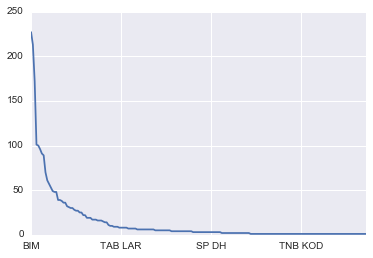

In [44]:
products.brand.value_counts(dropna=False).plot()

In [48]:
products[['Has_choco', 'Has_vanilla', 'Has_multigrano']].mean()

Has_choco         0.069059
Has_vanilla       0.036651
Has_multigrano    0.024306
dtype: float64

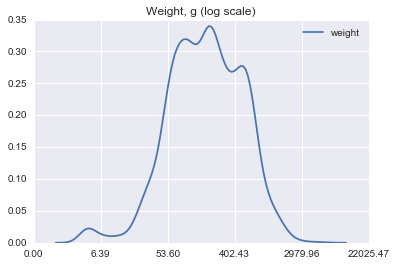

In [88]:
ax = sns.kdeplot(products.weight.apply(np.log))
xvals = ax.get_xticks()
_ = plt.xticks(xvals, ['%0.2f' % (np.exp(int(x))-1) for x in xvals])
_ = plt.title('Weight, g (log scale)')

In [91]:
clients = pd.read_csv('cliente_tabla.csv', index_col = 0)

clients.NombreCliente.value_counts().head(20)

NO IDENTIFICADO    281670
LUPITA               4863
MARY                 3016
LA PASADITA          2426
LA VENTANITA         2267
LA GUADALUPANA       1299
ROSY                 1245
ALEX                 1242
GABY                 1238
LA ESCONDIDA         1216
PATY                 1145
LA ESPERANZA         1139
HERNANDEZ            1129
LA CHIQUITA          1117
DANY                 1082
GARCIA               1062
JUQUILITA            1022
MARTINEZ              987
LA TIENDITA           914
3 HERMANOS            913
Name: NombreCliente, dtype: int64

In [92]:

clients.NombreCliente.replace(['SIN NOMBRE',
                               'NO IDENTIFICADO'], np.nan, inplace=True)
clients.head()


,NombreCliente
Cliente_ID,
0,NaN
1,OXXO XINANTECATL
2,NaN
3,EL MORENO
4,SDN SER DE ALIM CUERPO SA CIA DE INT


# Merged data exploration
See preprocessing.py

In [2]:
data_train = pd.read_csv('train_sample.csv')
data_train.head()

,Semana,Canal_ID,Ruta_SAK,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,Town,State,NombreProducto,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente,Log_Demanda
0,3,7,3301,4,39.32,0,0.0,4,2008 AG. LAGO FILT,"MEXICO, D.F.",Panquecito Gota Choc 2p 140g BIM 1238,BIM,140.0,2.0,0,0,0,PUESTO DE PERIODICOS LAZARO,1.609438
1,3,7,3301,23,458.62,0,0.0,23,2008 AG. LAGO FILT,"MEXICO, D.F.",Pan Blanco 640g BIM 2233,BIM,640.0,NaN,0,0,0,GUADALAJARA,3.178054
2,3,7,3301,14,279.16,0,0.0,14,2008 AG. LAGO FILT,"MEXICO, D.F.",Pan Blanco 640g BIM 2233,BIM,640.0,NaN,0,0,0,SANATORIO ESPANOL SA,2.708050
3,3,7,3301,6,37.50,0,0.0,6,2008 AG. LAGO FILT,"MEXICO, D.F.",Polvoron 6p 113g MLA 31506,MLA,113.0,6.0,0,0,0,PUESTO DEGALLETAS,1.945910
4,3,7,3301,12,75.00,0,0.0,12,2008 AG. LAGO FILT,"MEXICO, D.F.",Barritas Fresa 67g MLA 30571,MLA,67.0,NaN,0,0,0,COMEDOR WINS,2.564949


In [3]:
pd.crosstab(data_train.Dev_uni_proxima.apply(np.sign), data_train.Dev_proxima.apply(np.sign))

Dev_proxima,0.0,1.0
Dev_uni_proxima,,
0,486775,0
1,0,17267


Жадные владельцы магазинов не заказывают излишки:) кому-то явно не хватает булочек при таком соотношении

In [14]:
import unicodedata

for c in data_train.columns:
    if data_train[c].dtype.name == 'object': #string
        d_enc = {}
        for s in data_train[c].unique():
            if type(s) == str or type(s) == unicode:
                encoded  = unicodedata.normalize('NFKD', s.decode('utf-8')).encode('ascii','ignore')
                if s != encoded:
                    d_enc[s] = encoded
            else:
                print(c, s)
        
        data_train[c] = data_train[c].apply(lambda x: d_enc.get(x, x))

NombreCliente nan


In [4]:
data_train.State.value_counts()

ESTADO DE MEXICO         73609
MEXICO, D.F.             52318
JALISCO                  44081
PUEBLA                   29415
VERACRUZ                 27974
GUANAJUATO               26932
NUEVO LEON               24449
MICHOACAN                22626
HIDALGO                  15604
TAMAULIPAS               15043
CHIHUAHUA                12562
COAHUILA                 11995
BAJA CALIFORNIA NORTE    11623
OAXACA                   11266
SONORA                   11028
GUERRERO                 10823
SINALOA                   9682
MORELOS                   9470
SAN LUIS POTOSI           9326
TABASCO                   8888
AGUASCALIENTES            8708
CHIAPAS                   7184
DURANGO                   6735
YUCATAN                   6687
ZACATECAS                 5877
NAYARIT                   5463
COLIMA                    4462
QUINTANA ROO              4405
TLAXCALA                  3562
CAMPECHE                  3479
Queretaro de Arteaga      3392
BAJA CALIFORNIA SUR       3240
QUERETAR

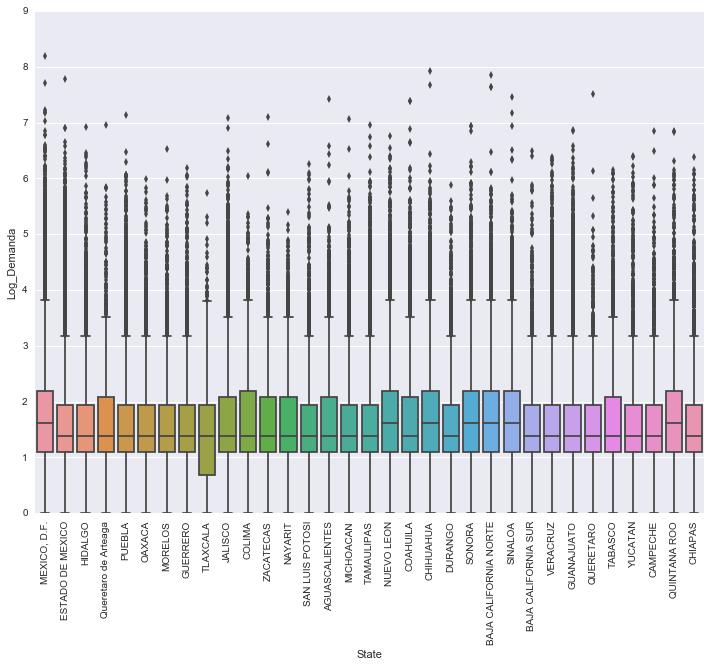

In [9]:
plt.figure(figsize=(12,9))
ax = sns.boxplot(x="State", y="Log_Demanda", data=data_train)
_= plt.xticks(rotation='vertical')

In [15]:
import pandas_profiling
pandas_profiling.ProfileReport(data_train)

Number of variables,21
Number of observations,504042
Total Missing (%),2.6%
Total size in memory,80.8 MiB
Average record size in memory,168.0 B
Numeric,16
Categorical,4
Date,0
Text (Unique),0
Rejected,1
Distinct count,551


In [7]:
data_train = pd.read_csv('train_sample.csv')
data_train.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente,Log_Demanda,Dev_proxima_by_uni,No_remains
0,3,1110,7,3301,15766,1238,4,39.32,0,0.0,...,BIM,140.0,2.0,0,0,0,PUESTO DE PERIODICOS LAZARO,1.609438,NaN,0
1,3,1110,7,3301,319641,1125,50,480.00,0,0.0,...,TR,255.0,10.0,0,0,0,GUADALAJARA,3.931826,NaN,0
2,3,1110,7,3301,319641,2233,23,458.62,0,0.0,...,BIM,640.0,NaN,0,0,0,GUADALAJARA,3.178054,NaN,0
3,3,1110,7,3301,819816,2233,14,279.16,0,0.0,...,BIM,640.0,NaN,0,0,0,SANATORIO ESPANOL SA,2.708050,NaN,0
4,3,1110,7,3301,1163700,31506,6,37.50,0,0.0,...,MLA,113.0,6.0,0,0,0,PUESTO DEGALLETAS,1.945910,NaN,0


In [3]:
print(str(data_train.columns))

Index([u'Semana', u'Agencia_ID', u'Canal_ID', u'Ruta_SAK', u'Cliente_ID',
       u'Producto_ID', u'Venta_uni_hoy', u'Venta_hoy', u'Dev_uni_proxima',
       u'Dev_proxima', u'Demanda_uni_equil', u'Town', u'State',
       u'NombreProducto', u'brand', u'weight', u'pieces', u'Has_choco',
       u'Has_vanilla', u'Has_multigrano', u'NombreCliente', u'Log_Demanda',
       u'Dev_proxima_by_uni', u'No_remains'],
      dtype='object')


In [4]:
data_train['No_remains']

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
1008043    0
1008044    0
1008045    0
1008046    0
1008047    0
1008048    0
1008049    0
1008050    0
1008051    0
1008052    0
1008053    0
1008054    0
1008055    0
1008056    0
1008057    0
1008058    0
1008059    0
1008060    0
1008061    0
1008062    0
1008063    0
1008064    0
1008065    0
1008066    0
1008067    0
1008068    0
1008069    1
1008070    1
1008071    0
1008072    0
Name: No_remains, dtype: int64

## Иерархия категорий

In [13]:
geo = ['Agencia_ID', 'Town', 'State']
product = ['Producto_ID', 'brand']
client = ['Cliente_ID', 'NombreCliente']
time = ['Semana']
other = ['Canal_ID']



In [15]:
a = data_train.groupby('Agencia_ID')['Cliente_ID'].apply(lambda lst: len(lst.unique()))
data_train.loc[data_train['Agencia_ID'] == a.argmax()].groupby('Cliente_ID').head(1).head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente,Log_Demanda,Dev_proxima_by_uni,No_remains
8956,3,1123,1,1001,201082,31392,2,44.44,0,0.0,...,BIM,640.0,NaN,0,0,0,LAS UNIDADES,1.098612,NaN,0
8957,3,1123,1,1001,203861,73,1,21.32,0,0.0,...,BIM,540.0,NaN,0,0,1,LUIGUI,0.693147,NaN,0
8958,3,1123,1,1001,577178,1146,1,21.39,0,0.0,...,BIM,675.0,NaN,0,0,0,GLORIA,0.693147,NaN,0
8959,3,1123,1,1001,874644,1160,5,94.30,0,0.0,...,BIM,450.0,8.0,0,0,0,SAN FRANCISCO,1.791759,NaN,0
8960,3,1123,1,1001,874897,1150,3,41.88,0,0.0,...,BIM,340.0,8.0,0,0,0,LORENA,1.386294,NaN,0


In [17]:
a = data_train.groupby('Agencia_ID')['Cliente_ID'].apply(lambda lst: len(lst.unique()))
print(a.max())
data_train.loc[data_train['Agencia_ID'] == a.argmax()].groupby('Cliente_ID').head(1).head()

4661


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente,Log_Demanda,Dev_proxima_by_uni,No_remains
8956,3,1123,1,1001,201082,31392,2,44.44,0,0.0,...,BIM,640.0,NaN,0,0,0,LAS UNIDADES,1.098612,NaN,0
8957,3,1123,1,1001,203861,73,1,21.32,0,0.0,...,BIM,540.0,NaN,0,0,1,LUIGUI,0.693147,NaN,0
8958,3,1123,1,1001,577178,1146,1,21.39,0,0.0,...,BIM,675.0,NaN,0,0,0,GLORIA,0.693147,NaN,0
8959,3,1123,1,1001,874644,1160,5,94.30,0,0.0,...,BIM,450.0,8.0,0,0,0,SAN FRANCISCO,1.791759,NaN,0
8960,3,1123,1,1001,874897,1150,3,41.88,0,0.0,...,BIM,340.0,8.0,0,0,0,LORENA,1.386294,NaN,0


In [23]:
a = data_train.groupby('Agencia_ID')['Ruta_SAK'].apply(lambda lst: len(lst.unique()))
print(a.max())
data_train.loc[data_train['Agencia_ID'] == a.argmax()].groupby('Ruta_SAK').head(1).head()

102


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,Town,State,NombreProducto,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente
186272,3,22560,1,900,4667610,73,21,237.30,0,0.0,...,2560 LAS TORRES,SONORA,Pan Multigrano Linaza 540g BIM 73,BIM,540.0,NaN,0,0,1,NaN
186746,3,22560,1,1070,29675,1146,2,42.78,0,0.0,...,2560 LAS TORRES,SONORA,Pan Integral 675g BIM 1146,BIM,675.0,NaN,0,0,0,PEQUES
187172,3,22560,1,1071,48833,1109,1,15.01,0,0.0,...,2560 LAS TORRES,SONORA,Pan Blanco Chico 360g BIM 1109,BIM,360.0,NaN,0,0,0,ARACELY
187542,3,22560,1,1072,40915,73,42,895.44,0,0.0,...,2560 LAS TORRES,SONORA,Pan Multigrano Linaza 540g BIM 73,BIM,540.0,NaN,0,0,1,MINISUPER ACOSTA
187961,3,22560,1,1073,40868,3631,3,49.05,0,0.0,...,2560 LAS TORRES,SONORA,Pan Integral 370g BIM 3631,BIM,370.0,NaN,0,0,0,FRUTERIA DEL MA YO


# Автокорелляции

In [19]:
data_train = pd.read_csv('train_SONORA_timeseries.csv')
print(data_train.shape)
data_train.head()

(1623938, 52)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,Town,State,NombreProducto,brand,weight,pieces,Has_choco,Has_vanilla,Has_multigrano,NombreCliente
0,3,1512,7,3310,39502,1146,6,128.34,0,0.0,...,2520 HERMOSILLO SUR,SONORA,Pan Integral 675g BIM 1146,BIM,675.0,NaN,0,0,0,SECUNADARIA NO 60
1,3,1512,7,3310,70786,1146,86,1839.54,0,0.0,...,2520 HERMOSILLO SUR,SONORA,Pan Integral 675g BIM 1146,BIM,675.0,NaN,0,0,0,U T H
2,3,1512,7,3310,70786,1216,28,234.64,0,0.0,...,2520 HERMOSILLO SUR,SONORA,Roles Glass 2p 135g BIM 1216,BIM,135.0,2.0,0,0,0,U T H
3,3,1512,7,3310,70786,1240,21,175.98,0,0.0,...,2520 HERMOSILLO SUR,SONORA,Mantecadas Vainilla 4p 125g BIM 1240,BIM,125.0,4.0,0,1,0,U T H
4,3,1512,7,3310,70786,1250,21,160.44,0,0.0,...,2520 HERMOSILLO SUR,SONORA,Donas Azucar 4p 105g BIM 1250,BIM,105.0,4.0,0,0,0,U T H


In [24]:
data_train = data_train.set_index(['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID'])
data_train.head()

Venta_uni_hoy  \
Semana Agencia_ID Canal_ID Ruta_SAK Cliente_ID Producto_ID                  
3      1512       7        3310     39502      1146                     6   
                                    70786      1146                    86   
                                               1216                    28   
                                               1240                    21   
                                               1250                    21   
                                               3894                    75   
                                               4085                    60   
                                               4280                    12   
                                               5000                    35   
                                               5328                    13   
                                               5337                    20   
                                               5355                    40   
                                               5380                    31   
                                               30531                  108   
                                               30568                   73   
                                               30571                   67   
                                               30574                   82   
                                               31309                   72   
                                               31506                   84   
                                               32939                  130   
                                               34053                   20   
                                               37057                   20   
                                    161123     1373                     3   
                                               2233                     6   
                                    162129     1146                     7   
                                    183902     1373                     2   
                                               2233                     1   
                                    351850     1146                     2   
                                               5380                     2   
                                    822412     3526                    16   
...                                                                   ...   
9      22560      1        5522     2341246    35106                    2   
                                               45143                   40   
                                    2352341    45143                   80   
                                    4212450    31719                    2   
                                    4219532    32860                    2   
                                    4257710    45143                   40   
                                    4302616    45143                   40   
                                    4336018    45143                   40   
                                    4445970    4280                    15   
                                               30214                    6   
                                               31184                    7   
                                               32863                    8   
                                               37577                   30   
                                               37580                   22   
                                               44495                   16   
                                    4476795    3526                    10   
                                               32863                    4   
                                               35130                    5   
                                               35144                   16   
                                               35147    

In [41]:
data_train = data_train.reset_index()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

text_cat = ['Town' ,'State' ,'NombreProducto' ,'brand', 'NombreCliente']
categories = data_train[text_cat].copy()

for c in categories.columns:
    categories[c] = categories[c].astype('category').cat.codes
    
categories['NombreCliente'] = categories['NombreCliente'] - categories['NombreCliente'].min()

enc = OneHotEncoder()

encoded = enc.fit_transform(categories)


In [ ]:
data_for_model = pd.concat([pd.DataFrame(encoded.toarray()), data_train.drop(text_cat, axis=1)], axis=1)
data_for_model.head()

In [ ]:
data_for_model['Log_Demanda'] = data_for_model.Demanda_uni_equil.apply(np.log1p)
data_for_model.drop('Demanda_uni_equil', axis=1, inplace=True)

In [ ]:
elasticNet.fit(data_for_model.drop(['Log_Demanda'], axis = 1), 
                         y= data_for_model['Log_Demanda'])

pd.Series(elasticNet.coef_, index=data_train.drop(text_features+['Log_Demanda'], axis = 1).columns)